### Modelling MMRs
#### Common Code for a SIR model with vaccination rate and age structure (6 classes)

In [2]:
import numpy as np
#import random
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

Model parameters

Parameters from Mel's paper and 4 age groups

In [20]:
Λ = 650 #e3 #/week #birth rate, scalar
θ = 0.8 # #immunization rate, scalar
σ = 0.95 #efficacy of vaccine, scalar
#I am using just the second efficacy

# is it the case that vaccines are less effective depending on age ?
#d = np.array([0, 0, 0, 0, 0, 0]).reshape(6,1)  #natural death rate for each age class 6x1
d = 0.00029 * np.ones(4) #/week
#α = np.array([Na, Na, Na, Na, Na, 0]) # aging rate for each age class, 6x1
α = 0.00385 * np.ones(4) #/week
#γ = np.array([]) #recovery rate for each age class, 6x1
γ = 0.024368 * np.ones(4)

#VACCINATION COMPARTMENT


#Number of compartments
Komp = 3

In [4]:
#Transmission matrix
b = np.array([0.167989e-06, 0.515425e-07, 0.262981e-07, 0.285701e-08 ]) #probability that the disease is trasmitted (of getting it) per contact b_k for people in age class k, 6x1
C = np.array([[13.3, 5.88, 3.08, 27.65],[6.02, 46.02, 8.26, 38.29],[3.22, 8.54, 48.3, 37.94],[4.41, 6.02, 5.74, 73.5]]) 
#c_{k,j} =  avg # contacts from age group j to age group k

#TRANSMISSION MATRIX
B = np.diag(b) @ C
# b_{k, j} = (avg) # transmissions in group k from group j 

In [5]:
def SIR_age_V(t, z):
    #extract 6x1 vectors
    K_max = int(len(z)/3)
    
    S = z[0:K_max]
    I = z[K_max:(K_max*2)]
    R = z[(K_max*2):]
    
    dS_1 = (1- θ*σ)*Λ - np.sum(B[0,].reshape(K_max,) * I) * S[0] - d[0]*S[0] - α[0]*S[0]
    dI_1 = np.sum(B[0,].reshape(K_max,) * I) * S[0] - (d[0]+γ[0]+α[0])*I[0]
    dR_1 = θ*σ*Λ + γ[0]*I[0] - d[0]*R[0] -α[0]*R[0]
    
    #we deal with the remaining 5 class in matrix form
    dS_k = (α * S)[0:-1] - (np.sum((B @ np.diag(I)), axis=1) * S)[1:] - (d * S)[1:] - (α * S)[1:]
    dI_k = (α * I)[0:-1] + (np.sum((B @ np.diag(I)), axis=1) * S)[1:] - ((d+ γ + α) * I)[1:]
    dR_k = (α * R)[0:-1] + (γ * I)[1:] - (d * R)[1:] - (α * R)[1:]
    
    SOLUT = np.concatenate(([dS_1], dS_k, [dI_1], dI_k, [dR_1], dR_k))
    return SOLUT

Initial conditions

In [6]:
S_0=np.array([10000,10000,10000,10000])  #6x1
I_0=np.array([200, 150, 50, 50])
R_0 = 10000-S_0-I_0
MaxTime=52*2 #years

Solving

In [7]:
# the ranges of my T, D, S are contained in the rows of z
sol_1year = solve_ivp(SIR_age_V, t_span = (0, MaxTime), y0 = np.concatenate((S_0,I_0,R_0)), t_eval = np.linspace(0,MaxTime ))
Y = sol_1year.y
t = sol_1year.t

#Output will be a Y that is 

In [8]:
Y.shape

(12, 50)

Plotting

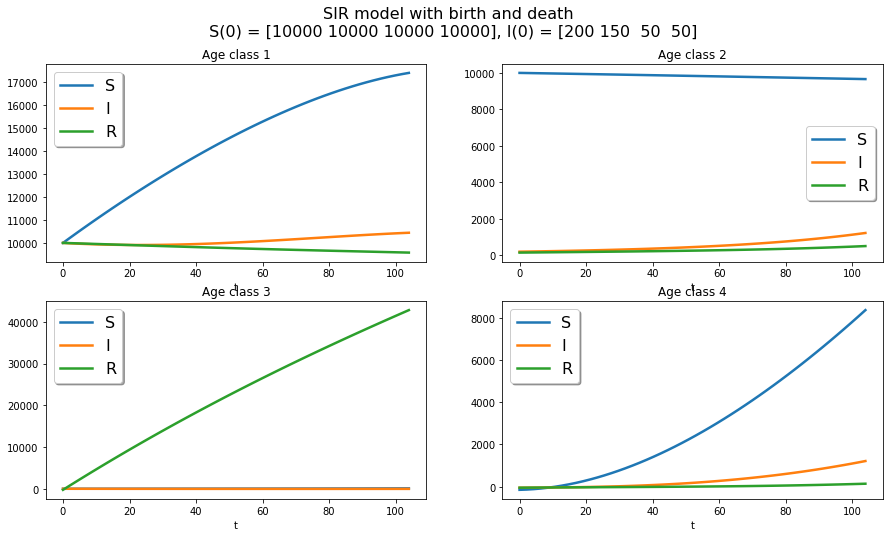

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(15,8))

fig.suptitle('SIR model with birth and death \n S(0) = {}, I(0) = {}'.format(S_0, I_0), fontsize=16)


for age_kl in np.arange(0, len(axs.flat)):
    ax = axs.flat[age_kl]
    ax.set(xlabel='t', ylabel='')
    ax.plot(t, Y[age_kl*Komp,:], label="S", lw=2.5)
    ax.plot(t, Y[age_kl*Komp+1,:], label="I", lw=2.5)
    ax.plot(t, Y[age_kl*Komp+2,:], label="R", lw=2.5)
    #plt.plot(t, np.repeat(1/R0, len(t)), label ="Equilibrium: S* = 1/R0")
    #plt.yscale("log")
    ax.legend(shadow=True, fontsize=16)
    ax.set_title("Age class {}".format(age_kl+1))

Discrete Aging

In [ ]:
#this depends on the structure of our age classes
Age_vec = [] 